narrative_tfidf, tfidf_title, tfidf_keywords	XGBoost  	0.664090	0.559104	0.456817	0.467326  

In [1]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from gensim.models import KeyedVectors
import pandas as pd
from sklearn.model_selection import cross_val_score, learning_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel 
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import warnings

In [2]:
import numpy as np
np.random.seed(42)  # Set random seed for numpy

import random
random.seed(42)  # Set random seed for random module

In [3]:
df = pd.read_csv("D:\\MS DATA SCIENCE\\NLP TESE\\data\\data_processed_selected.csv")
df.head()

,date,title,reason,description,zone,narrative_tfidf,narrative_embeddings,narrative_bert,narrative_tfidf_title,narrative_bert_title,...,embeddings_title,tfidf_keywords,embeddings_keywords,events_clean,results_final,events_tfidf,events_embeddings,orgs,locs,entities
0,2021-10-11 12:26:32,CTT - Encomenda entregue danificada e com etiq...,0,Bom dia venho por este meio apresentar uma rec...,Lisboa,bom dia venho meio apresentar reclamação ctt e...,bom dia venho por este meio apresentar uma rec...,Bom dia venho por este meio apresentar uma rec...,ctt encomenda entregar danificar etiqueta envi...,ctt - encomenda entregue danificada e com etiq...,...,ctt - encomenda entregue danificada e com etiq...,apresentar reclamação caixa figura envio israe...,apresentar uma reclamação tinha caixa figura e...,venho apresentar enviei destinado feito proteg...,"[('CTT', 'B-ORGANIZACAO'), ('Israel', 'B-LOCAL...",venho apresentar enviar destinar fazer protege...,venho apresentar enviei destinado feito proteg...,"CTT, Aboboda",Israel,"CTT, Aboboda, Israel"
1,2021-08-31 23:20:15,CTT - Carta com certificado rasgado!,1,- Boa Noite!\r\n\r\n- Venho por este meio recl...,Coimbra,bom noite venho meio reclamar data ás durante ...,- boa noite!\r\n\r\n- venho por este meio recl...,- Boa Noite! Venho por este meio reclamar que ...,ctt carta certificar rasgar bom noite venho me...,ctt - carta com certificado rasgado! - Boa No...,...,ctt - carta com certificado rasgado !,lilia pimentel certificar profissional passage...,lilia pimentel certificado profissional passag...,venho reclamar deparei -me continha tem,"[('Lilia', 'B-PESSOA'), ('Pimentel', 'I-PESSOA')]",venho reclamar deparar conter,venho reclamar deparei - me continha tem,NaN,NaN,NaN
2,2021-02-01 19:08:32,CTT - Encomenda registada que nunca chegou ao ...,2,"Boa tarde,\r\nNo dia 17 de Dezembro de 2020 en...",Aveiro,bom tarde dia dezembro enviar encomenda França...,"boa tarde,\r\nno dia 00 de dezembro de 0000 en...","Boa tarde, No dia 17 de Dezembro de 2020 envie...",ctt encomenda registar nunca chegar destine o ...,ctt - encomenda registada que nunca chegou ao ...,...,ctt - encomenda registada que nunca chegou ao ...,frança correio registar frança correio encomen...,frança em correio registado frança em correio ...,enviei registado vejo chegou saiu chegou tem p...,"[('França', 'B-LOCAL'), ('Roissy', 'B-ORGANIZA...",enviar registar vejo chegar sair chegar passar...,enviei registado vejo chegou saiu chegou tem p...,Roissy,"França, ROISSY","Roissy, França, ROISSY"
3,2018-04-19 09:04:34,CTT - Correio Verde,2,"Bom dia,\n\nPretendia esclarecer uma situação ...",Lisboa,bom dia pretender esclarecer situação ocorrer ...,"bom dia,\n\npretendia esclarecer uma situação ...","Bom dia, Pretendia esclarecer uma situação que...",ctt correio verde bom dia pretender esclarecer...,"ctt - correio verde Bom dia, Pretendia esclar...",...,ctt - correio verde,pretender esclarecer situação pretender esclar...,pretendia esclarecer uma situação pretendia es...,pretendia esclarecer ocorreu desloquei dado fe...,"[('El', 'B-LOCAL'), ('Corte', 'I-LOCAL'), ('In...",pretender esclarecer ocorrer desloquei dar fec...,pretendia esclarecer ocorreu desloquei dado fe...,Correio,"El Corte Inglés, Lisboa Verde","Correio, El Corte Inglés, Lisboa Verde"
4,2019-07-04 10:20:41,"CTT - Aviso de recepção da carta registada, pr...",2,venho por este meio solicitar a vossa ajuda pa...,Porto,venho meio solicitar vosso ajudar saber onde e...,venho por este meio solicitar a vossa ajuda pa...,venho por este meio solicitar a vossa ajuda pa...,ctt aviso recepção carta registar preciso urge...,"ctt - aviso de recepção da carta registada, pr...",...,"ctt - aviso de recepção da carta registada , p...",papal centro pois preciso urgentemente pois pr...,papais para o centro pois preciso dele urgente...,venho solicitar saber onde se encontra regista...,[],venho solicitar saber onde encontrar registar ...,venho solicitar saber onde se encontra regista...,NaN,NaN,NaN


In [4]:
def preprocess_entities(row):
    if pd.isna(row)==False:
        entities = row.lower()  # Convert to lowercase
        entities = entities.replace(',', '')  # Remove commas
        entities = ' '.join(set(entities.split()))  # Convert to set to get unique values, then join back as a string
        return entities
df['entities'] = df['entities'].apply(preprocess_entities)

In [5]:
df['entities']

0                          israel ctt aboboda
1                                        None
2                               roissy frança
3        corte correio verde inglés el lisboa
4                                        None
                         ...                 
22425                unido portugal reino ctt
22426                                    None
22427                              aliexpress
22428                                  lisboa
22429                                    None
Name: entities, Length: 22430, dtype: object

In [6]:
df.columns

Index(['date', 'title', 'reason', 'description', 'zone', 'narrative_tfidf',
       'narrative_embeddings', 'narrative_bert', 'narrative_tfidf_title',
       'narrative_bert_title', 'narrative_embeddings_title', 'tfidf_title',
       'title_tfidf_nolemma', 'events', 'keywords', 'embeddings_title',
       'tfidf_keywords', 'embeddings_keywords', 'events_clean',
       'results_final', 'events_tfidf', 'events_embeddings', 'orgs', 'locs',
       'entities'],
      dtype='object')

## TF-IDF  

In [7]:
y=df['reason']
X = df[['narrative_tfidf', 'tfidf_title', 'tfidf_keywords', 'events_tfidf', 'entities']]

In [8]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Split the remaining data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=42)

# Print the shape of each set
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (15701, 5)
y_train shape: (15701,)
X_val shape: (3364, 5)
y_val shape: (3364,)
X_test shape: (3365, 5)
y_test shape: (3365,)


In [9]:
X_train_val = pd.concat([X_train, X_val], axis=0, ignore_index=True)
y_train_val = pd.concat([y_train, y_val], axis=0, ignore_index=True)

## **1. XGBoost**   

<span style="color:white; font-size:18px;background-color:red">* Default XGBoost()</span>

In [59]:
import optuna
def objective(trial):
    feature_set=['narrative_tfidf', 'tfidf_title', 'tfidf_keywords']
    X_train_val_combined = X_train_val[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)
    X_test_combined = X_test[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)

    # Transform the features using TF-IDF
    vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_df=0.95, min_df=2)
    X_train_val_combined_transformed = vectorizer.fit_transform(X_train_val_combined)
    X_test_combined_transformed = vectorizer.transform(X_test_combined)

    # Define the hyperparameter search space
    params = {
      'objective': 'multi:softmax',
      'num_class': 4,
      'eval_metric': 'mlogloss',
      'eta': trial.suggest_float('eta', 0.01, 0.3),
      'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
      'max_depth': trial.suggest_int('max_depth', 3, 15),
      'subsample': trial.suggest_float('subsample', 0.5, 1.0),
      'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
      'min_child_weight': trial.suggest_int('min_child_weight', 2, 15),
      'gamma': trial.suggest_float("gamma", 0, 1),
      'random_state': 42,  # Add other hyperparameters as needed
      'reg_alpha': trial.suggest_float('reg_alpha',0, 1),              # L1 regularization term on weights
      'reg_lambda': trial.suggest_float('reg_lambda',0, 1)
    }

    # Create and train the XGBoost classifier with the current set of hyperparameters
    clf = XGBClassifier(**params)
    clf.fit(X_train_val_combined_transformed, y_train_val)

    # Evaluate the classifier on the validation set
    cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
    f1_scores = cross_val_score(clf, X_train_val_combined_transformed, y_train_val, cv=cv, scoring='f1_macro')

    return f1_scores.mean()

In [65]:
import os
path = 'D:\\MS DATA SCIENCE\\NLP TESE\\optuna'
database_filename = 'description_title_keywords.db'

# Full path to the SQLite database file in Google Drive
database_path = os.path.join(path, database_filename)

# Set the SQLite database path to Google Drive path
storage = optuna.storages.RDBStorage(url=f'sqlite:///{database_path}')

In [66]:
study = optuna.create_study(storage=storage, direction='maximize', study_name='description_title_keywords',load_if_exists=True)
study.optimize(objective, n_trials=50)

trial = study.best_trial
print('Val Loss: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2023-07-30 01:05:39,386] A new study created in RDB with name: description_title_keywords
[I 2023-07-30 01:46:59,940] Trial 0 finished with value: 0.45076536635853826 and parameters: {'colsample_bytree': 0.8481781819826891, 'eta': 0.024914580506785078, 'gamma': 0.600195402231574, 'max_depth': 5, 'min_child_weight': 12, 'n_estimators': 692, 'reg_alpha': 0.5941382665998689, 'reg_lambda': 0.289947460352284, 'subsample': 0.5247350747360959}. Best is trial 0 with value: 0.45076536635853826.
[I 2023-07-30 02:09:46,554] Trial 1 finished with value: 0.4702032121386974 and parameters: {'colsample_bytree': 0.7612560333215546, 'eta': 0.20632398379829894, 'gamma': 0.13331133924189265, 'max_depth': 4, 'min_child_weight': 12, 'n_estimators': 458, 'reg_alpha': 0.533366102451221, 'reg_lambda': 0.4725380046619754, 'subsample': 0.8383017824580684}. Best is trial 1 with value: 0.4702032121386974.
[I 2023-07-30 02:41:03,255] Trial 2 finished with value: 0.45874055358778176 and parameters: {'colsample_b

[I 2023-07-30 13:32:47,285] Trial 21 finished with value: 0.46498990467896845 and parameters: {'colsample_bytree': 0.5144170729865112, 'eta': 0.17741818251300137, 'gamma': 0.08851852845177571, 'max_depth': 7, 'min_child_weight': 14, 'n_estimators': 454, 'reg_alpha': 0.5480955109029495, 'reg_lambda': 0.8662270341787979, 'subsample': 0.8270276074795879}. Best is trial 1 with value: 0.4702032121386974.
[I 2023-07-30 14:03:44,680] Trial 22 finished with value: 0.4655855667756022 and parameters: {'colsample_bytree': 0.5576349696425419, 'eta': 0.13554886127155324, 'gamma': 0.004737494700155026, 'max_depth': 6, 'min_child_weight': 15, 'n_estimators': 604, 'reg_alpha': 0.4781702677533959, 'reg_lambda': 0.6642925938408274, 'subsample': 0.8027146105626319}. Best is trial 1 with value: 0.4702032121386974.
[I 2023-07-30 14:40:28,405] Trial 23 finished with value: 0.4660159468529745 and parameters: {'colsample_bytree': 0.6281076885514805, 'eta': 0.17537792340810762, 'gamma': 0.12321065825265394, 'm

[I 2023-07-31 03:01:41,950] Trial 42 finished with value: 0.46417681742625055 and parameters: {'colsample_bytree': 0.8123209026960019, 'eta': 0.21322609068686285, 'gamma': 0.31018013179752324, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 918, 'reg_alpha': 0.28260981317894973, 'reg_lambda': 0.343523971866212, 'subsample': 0.9403856352602971}. Best is trial 30 with value: 0.4720905631356927.
[I 2023-07-31 03:48:40,622] Trial 43 finished with value: 0.4703353965231631 and parameters: {'colsample_bytree': 0.7819888377930647, 'eta': 0.19061744654579565, 'gamma': 0.4600468156699826, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 843, 'reg_alpha': 0.20998074625355836, 'reg_lambda': 0.4263354584385572, 'subsample': 0.867035302343105}. Best is trial 30 with value: 0.4720905631356927.
[I 2023-07-31 04:41:15,326] Trial 44 finished with value: 0.47057481797004774 and parameters: {'colsample_bytree': 0.7385861791254164, 'eta': 0.2204403887709136, 'gamma': 0.3096562463971734, 'max_

Val Loss: 0.4734151878989077
Best hyperparameters: {'colsample_bytree': 0.6660707896339382, 'eta': 0.1865203620258158, 'gamma': 0.4869470425232074, 'max_depth': 5, 'min_child_weight': 8, 'n_estimators': 747, 'reg_alpha': 0.2615683528029101, 'reg_lambda': 0.20706126430246635, 'subsample': 0.87307714888806}


In [ ]:
# in case it fails
# Load the existing study by providing the study name and storage URL
study = optuna.load_study(study_name='description_title_keywords', storage=storage)

# Continue optimization with additional trials
study.optimize(objective, n_trials=50)

trial = study.best_trial
print('Val Loss: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

In [16]:
feature_set=['narrative_tfidf', 'tfidf_title', 'tfidf_keywords']
X_train_val_combined = X_train_val[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)
X_test_combined = X_test[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)

# Transform the features using TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_df=0.95, min_df=2)
X_train_val_combined_transformed = vectorizer.fit_transform(X_train_val_combined)
X_test_combined_transformed = vectorizer.transform(X_test_combined)


best_model = XGBClassifier(
    colsample_bytree=0.6660707896339382,
    eta=0.1865203620258158,
    gamma=0.4869470425232074,
    max_depth=5,
    min_child_weight=8,
    n_estimators=747,
    reg_alpha=0.2615683528029101,
    reg_lambda=0.20706126430246635,
    subsample=0.87307714888806
)
cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
f1_scores = cross_val_score(best_model, X_train_val_combined_transformed, y_train_val, cv=cv, scoring='f1_macro')
acc_scores = cross_val_score(best_model, X_train_val_combined_transformed, y_train_val, cv=cv, scoring='accuracy')
rec_scores = cross_val_score(best_model, X_train_val_combined_transformed, y_train_val, cv=cv, scoring='recall_macro')
prec_scores = cross_val_score(best_model, X_train_val_combined_transformed, y_train_val, cv=cv, scoring='precision_macro')

print("Individual fold F1-scores:", f1_scores)
print("Mean cross-validation F1-score:", f1_scores.mean())
print("Individual Precision:", prec_scores)
print("Mean cross-validation Precision:", prec_scores.mean())
print("Individual Accuracy:", acc_scores)
# or np.mean
print("Mean cross-validation Accuracy:", acc_scores.mean())
print("Individual Recall:", rec_scores)
print("Mean cross-validation Recall:", rec_scores.mean())

Individual fold F1-scores: [0.46351798 0.4781506  0.46642378 0.45866256 0.46751138 0.48285707]
Mean cross-validation F1-score: 0.46952056262192415
Individual Precision: [0.51388756 0.54248004 0.51866748 0.53119626 0.52422632 0.53729532]
Mean cross-validation Precision: 0.5279588297059851
Individual Accuracy: [0.65040906 0.66173694 0.64694777 0.64431854 0.65879761 0.65659427]
Mean cross-validation Accuracy: 0.6531340313833981
Individual Recall: [0.45259352 0.46284257 0.45552786 0.44587416 0.45587508 0.46703823]
Mean cross-validation Recall: 0.4566252370648251


test classification report
              precision    recall  f1-score   support

           0       0.58      0.61      0.60      1195
           1       0.25      0.10      0.14       333
           2       0.72      0.84      0.77      1609
           3       0.41      0.21      0.27       228

    accuracy                           0.64      3365
   macro avg       0.49      0.44      0.45      3365
weighted avg       0.60      0.64      0.61      3365



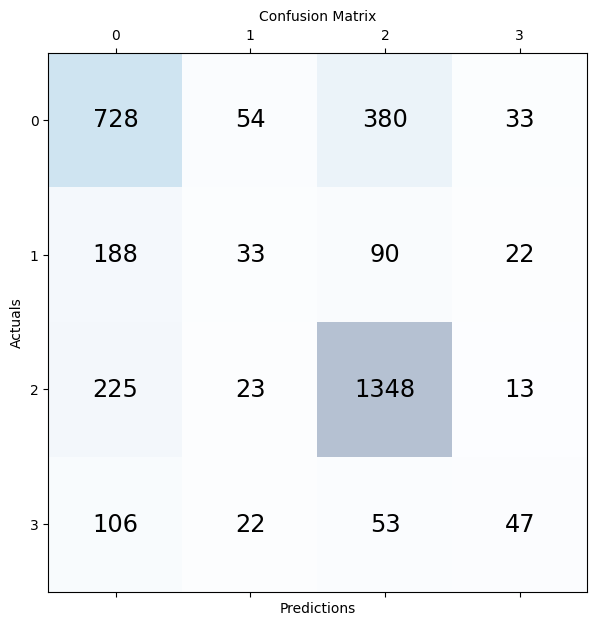

In [17]:
# Retrain on full training set using the best hyperparameters
best_model.fit(X_train_val_combined_transformed, y_train_val)

# Make predictions on the test dataset
y_pred_test = best_model.predict(X_test_combined_transformed)
print('test classification report')
print(classification_report(y_test, y_pred_test))

# Print the confusion matrix
fig, ax = plt.subplots(figsize=(7, 7))
confusion_mat = confusion_matrix(y_true=y_test, y_pred=y_pred_test, labels=[0,1,2,3])
ax.matshow(confusion_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_mat.shape[0]):
    for j in range(confusion_mat.shape[1]):
        ax.text(x=j, y=i,s=confusion_mat[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=10)
plt.ylabel('Actuals', fontsize=10)
plt.title('Confusion Matrix', fontsize=10)
plt.show()
print('\n')

In [18]:
# Plot Learning Curves
def plot_learning_curve(best_model, X_train_val_combined_transformed, y_train_val, scoring):
    # Create StratifiedKFold cross-validator with 6 folds
    stratified_cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)

    train_sizes, train_scores, val_scores = learning_curve(best_model, X_train_val_combined_transformed, y_train_val, cv=stratified_cv, 
                                                           scoring=scoring, train_sizes=np.linspace(0.1, 1.0, 10),
                                                           random_state=42)

    # Calculate mean and standard deviation of training and validation scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    valid_scores_mean = np.mean(val_scores, axis=1)
    valid_scores_std = np.std(val_scores, axis=1)

    # Plot learning curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label='Training score', color='blue')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2, color='blue')
    plt.plot(train_sizes, valid_scores_mean, label='Cross-validation score', color='red')
    plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                     valid_scores_mean + valid_scores_std, alpha=0.2, color='red')
    plt.xlabel('Number of Training Examples')
    plt.ylabel('{} Score'.format(scoring))
    plt.title('Learning Curves')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

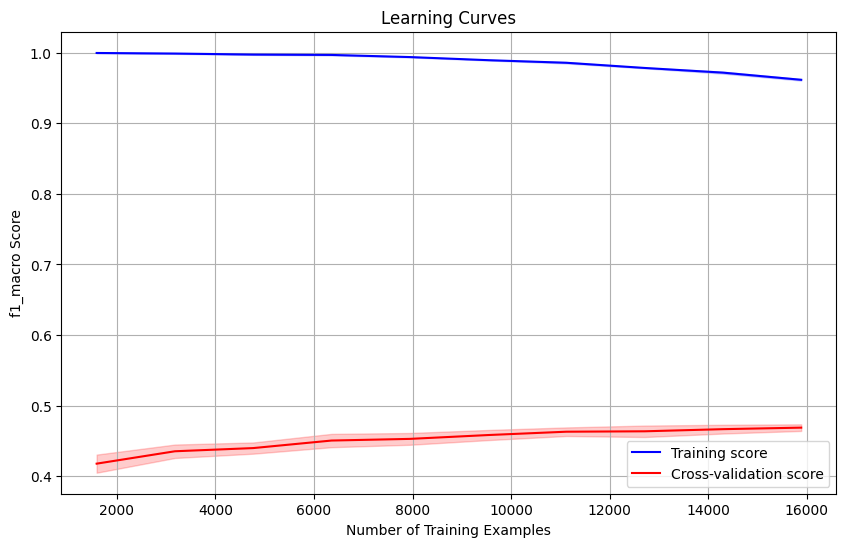

In [19]:
plot_learning_curve(best_model, X_train_val_combined_transformed, y_train_val, 'f1_macro')

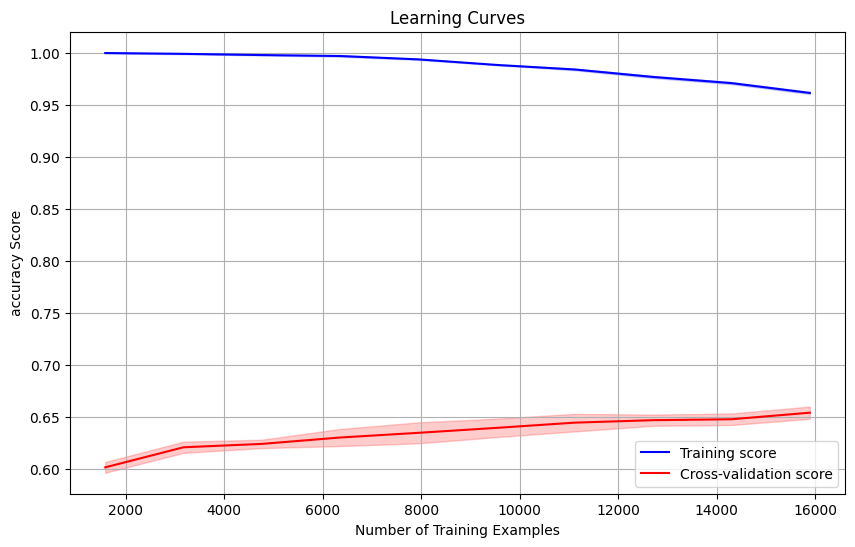

In [20]:
plot_learning_curve(best_model, X_train_val_combined_transformed, y_train_val, 'accuracy')

<span style="color:white; font-size:18px;background-color:red">* Training XGBoost with Class Weighting</span>  

In [ ]:
feature_set=['narrative_tfidf', 'tfidf_title', 'tfidf_keywords']
X_train_val_combined = X_train_val[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)
X_test_combined = X_test[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)

# Transform the features using TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_df=0.95, min_df=2)
X_train_val_combined_transformed = vectorizer.fit_transform(X_train_val_combined)
X_test_combined_transformed = vectorizer.transform(X_test_combined)

best_model = XGBClassifier(
    colsample_bytree=0.6512388819343109,
    eta=0.2011426906334458,
    gamma=0.7620849043646142,
    max_depth=4,
    min_child_weight=10,
    n_estimators=715,
    reg_alpha=0.5168759646324439,
    reg_lambda=0.39913638872637947,
    subsample=0.9273881699037634
)

best_model.fit(X_train_val_combined_transformed, y_train_val)

<span style="color:white; font-size:18px;background-color:red">* Resampling with smote</span>

In [38]:
feature_set=['narrative_tfidf', 'tfidf_title', 'tfidf_keywords']
X_train_val_combined = X_train_val[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)
X_test_combined = X_test[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)

# Transform the features using TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_df=0.95, min_df=2)
X_train_val_combined_transformed = vectorizer.fit_transform(X_train_val_combined)
X_test_combined_transformed = vectorizer.transform(X_test_combined)

smote=SMOTE(random_state=42, sampling_strategy='not majority')
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_val_combined_transformed, y_train_val)

best_model = XGBClassifier(
    colsample_bytree=0.6512388819343109,
    eta=0.2011426906334458,
    gamma=0.7620849043646142,
    max_depth=4,
    min_child_weight=10,
    n_estimators=715,
    reg_alpha=0.5168759646324439,
    reg_lambda=0.39913638872637947,
    subsample=0.9273881699037634
)

cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
f1_scores = cross_val_score(best_model, X_train_balanced, y_train_balanced, cv=cv, scoring='f1_macro')
acc_scores = cross_val_score(best_model, X_train_balanced, y_train_balanced, cv=cv, scoring='accuracy')
rec_scores = cross_val_score(best_model, X_train_balanced, y_train_balanced, cv=cv, scoring='recall_macro')
prec_scores = cross_val_score(best_model, X_train_balanced, y_train_balanced, cv=cv, scoring='precision_macro')

print("Individual fold F1-scores:", f1_scores)
print("Mean cross-validation F1-score:", f1_scores.mean())
print("Individual Precision:", prec_scores)
print("Mean cross-validation Precision:", prec_scores.mean())
print("Individual Accuracy:", acc_scores)
print("Mean cross-validation Accuracy:", acc_scores.mean())
print("Individual Recall:", rec_scores)
print("Mean cross-validation Recall:", rec_scores.mean())

Individual fold F1-scores: [0.81308492 0.83077559 0.82102635 0.82476896 0.82179431 0.81018466]
Mean cross-validation F1-score: 0.8202724648695038
Individual Precision: [0.81621396 0.83256544 0.82343561 0.82796032 0.82503628 0.81240248]
Mean cross-validation Precision: 0.8229356818528742
Individual Accuracy: [0.81266447 0.83092105 0.82036519 0.82381971 0.82069419 0.81000165]
Mean cross-validation Accuracy: 0.8197443772131844
Individual Recall: [0.81266447 0.83092105 0.8203707  0.82383656 0.82067269 0.81000431]
Mean cross-validation Recall: 0.8197449629257476


In [ ]:
plot_learning_curve(best_model, X_train_balanced, y_train_balanced, 'accuracy')

In [ ]:
plot_learning_curve(best_model, X_train_balanced, y_train_balanced, 'f1_macro')

In [ ]:
# Retrain on full training set using the best hyperparameters
best_model.fit(X_train_balanced, y_train_balanced)

# Make predictions on the test dataset
y_pred_test = best_model.predict(X_test_combined_transformed)
print('test classification report')
print(classification_report(y_test, y_pred_test))

# Print the confusion matrix
fig, ax = plt.subplots(figsize=(7, 7))
confusion_mat = confusion_matrix(y_true=y_test, y_pred=y_pred_test, labels=[0,1,2,3])
ax.matshow(confusion_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_mat.shape[0]):
    for j in range(confusion_mat.shape[1]):
        ax.text(x=j, y=i,s=confusion_mat[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=10)
plt.ylabel('Actuals', fontsize=10)
plt.title('Confusion Matrix', fontsize=10)
plt.show()
print('\n')

<span style="color:white; font-size:18px;background-color:red">* chi-square feature selection + hyperparameter tuning</span>

In [21]:
import optuna
def objective2(trial):
    feature_set=['narrative_tfidf', 'tfidf_title', 'tfidf_keywords']
    X_train_val_combined = X_train_val[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)
    X_test_combined = X_test[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)

    # Transform the features using TF-IDF
    vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_df=0.95, min_df=2)
    X_train_val_combined_transformed = vectorizer.fit_transform(X_train_val_combined)
    X_test_combined_transformed = vectorizer.transform(X_test_combined)

    # Nr features before
    feature_names = vectorizer.get_feature_names_out()
    num_features_before = len(feature_names)

    # Define the hyperparameter search space
    params = {
      'objective': 'multi:softmax',
      'num_class': 4,
      'eval_metric': 'mlogloss',
      'eta': trial.suggest_float('eta', 0.01, 0.3),
      'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
      'max_depth': trial.suggest_int('max_depth', 3, 15),
      'subsample': trial.suggest_float('subsample', 0.5, 1.0),
      'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
      'min_child_weight': trial.suggest_int('min_child_weight', 2, 15),
      'gamma': trial.suggest_float("gamma", 0, 1),
      'random_state': 42,  # Add other hyperparameters as needed
      'reg_alpha': trial.suggest_float('reg_alpha',0, 1),              # L1 regularization term on weights
      'reg_lambda': trial.suggest_float('reg_lambda',0, 1)
    }
    
    # Create and train the XGBoost classifier with the current set of hyperparameters
    clf = XGBClassifier(**params)
    
    # Perform feature selection with SelectKBest and chi2 score function
    best_k = trial.suggest_int('best_k', 100, (num_features_before// 2) + 1, step=100)
    selector = SelectKBest(score_func=chi2, k=best_k)
    X_train_selected = selector.fit_transform(X_train_val_combined_transformed, y_train_val)
    
    clf.fit(X_train_selected, y_train_val)

    # Evaluate the classifier on the validation set
    cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
    f1_scores = cross_val_score(clf, X_train_selected, y_train_val, cv=cv, scoring='f1_macro')

    return f1_scores.mean()

In [22]:
import os
path = 'D:\\MS DATA SCIENCE\\NLP TESE\\optuna'
database_filename = 'description_title_keywords_chi2.db'

# Full path to the SQLite database file in Google Drive
database_path = os.path.join(path, database_filename)

# Set the SQLite database path to Google Drive path
storage = optuna.storages.RDBStorage(url=f'sqlite:///{database_path}')

In [23]:
study = optuna.create_study(storage=storage, direction='maximize', study_name='description_title_keywords_chi2',load_if_exists=True)
study.optimize(objective2, n_trials=50)

trial = study.best_trial
print('Val Loss: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2023-08-01 04:35:23,619] A new study created in RDB with name: description_title_keywords_chi2
[I 2023-08-01 05:00:01,174] Trial 0 finished with value: 0.4758071270411723 and parameters: {'best_k': 19000, 'colsample_bytree': 0.6372300556489741, 'eta': 0.11634639083843275, 'gamma': 0.8059270570286402, 'max_depth': 14, 'min_child_weight': 11, 'n_estimators': 509, 'reg_alpha': 0.2129975897120766, 'reg_lambda': 0.4663462522099917, 'subsample': 0.936800957190444}. Best is trial 0 with value: 0.4758071270411723.
[I 2023-08-01 05:43:32,758] Trial 1 finished with value: 0.46736828918724466 and parameters: {'best_k': 59500, 'colsample_bytree': 0.901007355749329, 'eta': 0.13106513399634534, 'gamma': 0.04272235841699601, 'max_depth': 11, 'min_child_weight': 12, 'n_estimators': 864, 'reg_alpha': 0.04254157813403281, 'reg_lambda': 0.8515520173741137, 'subsample': 0.5588638079969619}. Best is trial 0 with value: 0.4758071270411723.
[I 2023-08-01 06:14:46,715] Trial 2 finished with value: 0.473108

[I 2023-08-01 11:53:51,244] Trial 20 finished with value: 0.4742578282185895 and parameters: {'best_k': 29500, 'colsample_bytree': 0.5861073637935637, 'eta': 0.1660241409017879, 'gamma': 0.8640505850195244, 'max_depth': 3, 'min_child_weight': 6, 'n_estimators': 669, 'reg_alpha': 0.48631858154595997, 'reg_lambda': 0.27918847958252946, 'subsample': 0.8154920464611142}. Best is trial 11 with value: 0.4766670642040112.
[I 2023-08-01 12:02:43,777] Trial 21 finished with value: 0.47945222220533745 and parameters: {'best_k': 29300, 'colsample_bytree': 0.5943825018218242, 'eta': 0.1655699753329909, 'gamma': 0.8441748165418191, 'max_depth': 3, 'min_child_weight': 6, 'n_estimators': 677, 'reg_alpha': 0.553447056714076, 'reg_lambda': 0.27531037692013316, 'subsample': 0.8263851907830191}. Best is trial 21 with value: 0.47945222220533745.
[I 2023-08-01 12:19:21,745] Trial 22 finished with value: 0.47671890699513897 and parameters: {'best_k': 43200, 'colsample_bytree': 0.6608892038826103, 'eta': 0.2

[I 2023-08-01 17:04:16,696] Trial 40 finished with value: 0.4709598249288118 and parameters: {'best_k': 51400, 'colsample_bytree': 0.5985767945971023, 'eta': 0.15558068071859824, 'gamma': 0.6061907072598719, 'max_depth': 8, 'min_child_weight': 9, 'n_estimators': 926, 'reg_alpha': 0.5359104979117599, 'reg_lambda': 0.6176191329645387, 'subsample': 0.9713815207146443}. Best is trial 32 with value: 0.47945427309192024.
[I 2023-08-01 17:23:51,885] Trial 41 finished with value: 0.4744749636733117 and parameters: {'best_k': 40400, 'colsample_bytree': 0.6418401400259653, 'eta': 0.17637929031714644, 'gamma': 0.7705943179951354, 'max_depth': 5, 'min_child_weight': 8, 'n_estimators': 829, 'reg_alpha': 0.4618573415177917, 'reg_lambda': 0.3943234259563254, 'subsample': 0.8731207560229218}. Best is trial 32 with value: 0.47945427309192024.
[I 2023-08-01 17:32:38,673] Trial 42 finished with value: 0.4755911882740677 and parameters: {'best_k': 16600, 'colsample_bytree': 0.6517440891599106, 'eta': 0.20

Val Loss: 0.47945427309192024
Best hyperparameters: {'best_k': 20100, 'colsample_bytree': 0.6512388819343109, 'eta': 0.2011426906334458, 'gamma': 0.7620849043646142, 'max_depth': 4, 'min_child_weight': 10, 'n_estimators': 715, 'reg_alpha': 0.5168759646324439, 'reg_lambda': 0.39913638872637947, 'subsample': 0.9273881699037634}


In [24]:
feature_set=['narrative_tfidf', 'tfidf_title', 'tfidf_keywords']
X_train_val_combined = X_train_val[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)
X_test_combined = X_test[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)

# Transform the features using TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_df=0.95, min_df=2)
X_train_val_combined_transformed = vectorizer.fit_transform(X_train_val_combined)
X_test_combined_transformed = vectorizer.transform(X_test_combined)

# Perform feature selection with SelectKBest and chi2 score function
selector = SelectKBest(score_func=chi2, k=20100)
X_train_selected = selector.fit_transform(X_train_val_combined_transformed, y_train_val)
X_test_selected = selector.transform(X_test_combined_transformed)

best_model = XGBClassifier(
    colsample_bytree=0.6512388819343109,
    eta=0.2011426906334458,
    gamma=0.7620849043646142,
    max_depth=4,
    min_child_weight=10,
    n_estimators=715,
    reg_alpha=0.5168759646324439,
    reg_lambda=0.39913638872637947,
    subsample=0.9273881699037634
)
cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
f1_scores = cross_val_score(best_model, X_train_selected, y_train_val, cv=cv, scoring='f1_macro')
acc_scores = cross_val_score(best_model, X_train_selected, y_train_val, cv=cv, scoring='accuracy')
rec_scores = cross_val_score(best_model, X_train_selected, y_train_val, cv=cv, scoring='recall_macro')
prec_scores = cross_val_score(best_model, X_train_selected, y_train_val, cv=cv, scoring='precision_macro')

print("Individual fold F1-scores:", f1_scores)
print("Mean cross-validation F1-score:", f1_scores.mean())
print("Individual Precision:", prec_scores)
print("Mean cross-validation Precision:", prec_scores.mean())
print("Individual Accuracy:", acc_scores)
print("Mean cross-validation Accuracy:", acc_scores.mean())
print("Individual Recall:", rec_scores)
print("Mean cross-validation Recall:", rec_scores.mean())

Individual fold F1-scores: [0.4573168  0.48403975 0.47795876 0.47405449 0.48379602 0.47217597]
Mean cross-validation F1-score: 0.4748902986761645
Individual Precision: [0.50197344 0.54405319 0.53399739 0.54442994 0.55848835 0.51865715]
Mean cross-validation Precision: 0.5335999097775778
Individual Accuracy: [0.6406545  0.6655129  0.65387036 0.65061379 0.66225999 0.65313189]
Mean cross-validation Accuracy: 0.6543405708866018
Individual Recall: [0.44686099 0.46900818 0.46294754 0.46034027 0.46701401 0.46011234]
Mean cross-validation Recall: 0.46104722219110644


test classification report
              precision    recall  f1-score   support

           0       0.58      0.62      0.59      1195
           1       0.35      0.12      0.17       333
           2       0.72      0.83      0.77      1609
           3       0.42      0.23      0.30       228

    accuracy                           0.64      3365
   macro avg       0.52      0.45      0.46      3365
weighted avg       0.61      0.64      0.62      3365



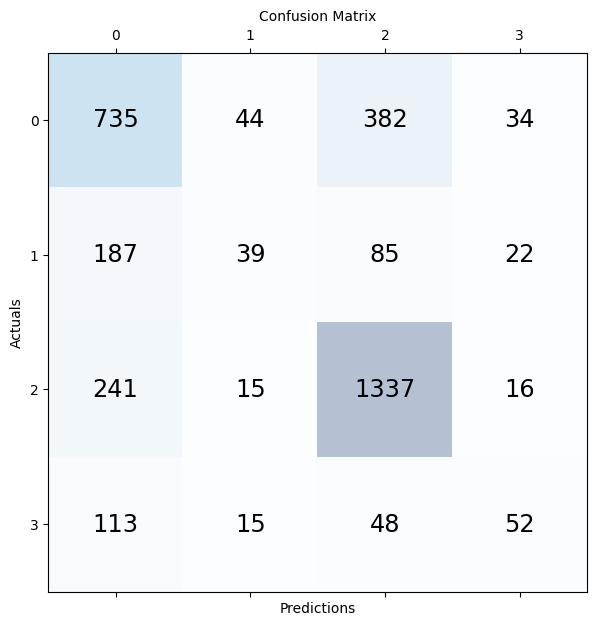

In [25]:
# Retrain on full training set using the best hyperparameters
best_model.fit(X_train_selected, y_train_val)

# Make predictions on the test dataset
y_pred_test = best_model.predict(X_test_selected)
print('test classification report')
print(classification_report(y_test, y_pred_test))

# Print the confusion matrix
fig, ax = plt.subplots(figsize=(7, 7))
confusion_mat = confusion_matrix(y_true=y_test, y_pred=y_pred_test, labels=[0,1,2,3])
ax.matshow(confusion_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_mat.shape[0]):
    for j in range(confusion_mat.shape[1]):
        ax.text(x=j, y=i,s=confusion_mat[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=10)
plt.ylabel('Actuals', fontsize=10)
plt.title('Confusion Matrix', fontsize=10)
plt.show()
print('\n')

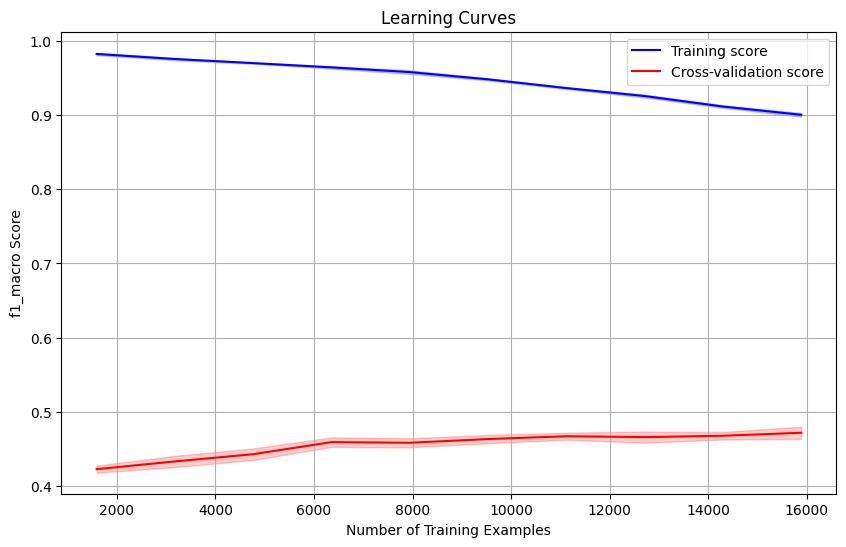

In [26]:
plot_learning_curve(best_model, X_train_selected, y_train_val, 'f1_macro')

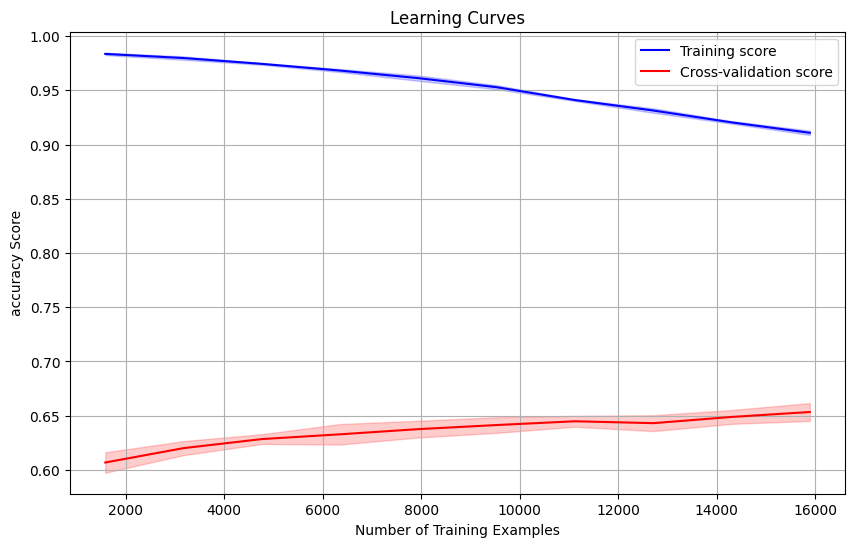

In [27]:
plot_learning_curve(best_model, X_train_selected, y_train_val, 'accuracy')

<span style="color:white; font-size:18px;background-color:red">* feature importance + hyperparameter tuning</span>

In [33]:
feature_set=['narrative_tfidf', 'tfidf_title', 'tfidf_keywords']
X_train_val_combined = X_train_val[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)
X_test_combined = X_test[feature_set].apply(lambda x: ' '.join(x.fillna('').astype(str)), axis=1)

# Transform the features using TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_df=0.95, min_df=2)
X_train_val_combined_transformed = vectorizer.fit_transform(X_train_val_combined)
X_test_combined_transformed = vectorizer.transform(X_test_combined)

best_model = XGBClassifier(
    colsample_bytree=0.6512388819343109,
    eta=0.2011426906334458,
    gamma=0.7620849043646142,
    max_depth=4,
    min_child_weight=10,
    n_estimators=715,
    reg_alpha=0.5168759646324439,
    reg_lambda=0.39913638872637947,
    subsample=0.9273881699037634
)

best_model.fit(X_train_val_combined_transformed, y_train_val)
feature_importances = best_model.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]  # Descending order
k = 20100 
selected_feature_indices = sorted_indices[:k]

# Create the reduced dataset with selected features
X_train_reduced = X_train_val_combined_transformed[:, selected_feature_indices]
X_test_reduced = X_test_combined_transformed[:, selected_feature_indices]

# Train the model on the reduced dataset
best_model_reduced = XGBClassifier(**best_model.get_params())  
best_model_reduced.fit(X_train_reduced, y_train_val)

cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
f1_scores = cross_val_score(best_model_reduced, X_train_reduced, y_train_val, cv=cv, scoring='f1_macro')
acc_scores = cross_val_score(best_model_reduced, X_train_reduced, y_train_val, cv=cv, scoring='accuracy')
rec_scores = cross_val_score(best_model_reduced, X_train_reduced, y_train_val, cv=cv, scoring='recall_macro')
prec_scores = cross_val_score(best_model_reduced, X_train_reduced, y_train_val, cv=cv, scoring='precision_macro')

print("Individual fold F1-scores:", f1_scores)
print("Mean cross-validation F1-score:", f1_scores.mean())
print("Individual Precision:", prec_scores)
print("Mean cross-validation Precision:", prec_scores.mean())
print("Individual Accuracy:", acc_scores)
print("Mean cross-validation Accuracy:", acc_scores.mean())
print("Individual Recall:", rec_scores)
print("Mean cross-validation Recall:", rec_scores.mean())

Individual fold F1-scores: [0.47755686 0.46781644 0.47280657 0.47781347 0.46899166 0.4782206 ]
Mean cross-validation F1-score: 0.4738676001555365
Individual Precision: [0.53816626 0.52954934 0.52114179 0.54435292 0.52691738 0.52605214]
Mean cross-validation Precision: 0.5310299711620295
Individual Accuracy: [0.65827565 0.66016362 0.65544368 0.65879761 0.66351904 0.65785332]
Mean cross-validation Accuracy: 0.659008819486662
Individual Recall: [0.46239802 0.45603999 0.46171046 0.46411199 0.45790264 0.4652973 ]
Mean cross-validation Recall: 0.46124339956597415


test classification report
              precision    recall  f1-score   support

           0       0.57      0.60      0.59      1195
           1       0.32      0.12      0.17       333
           2       0.72      0.84      0.78      1609
           3       0.42      0.21      0.28       228

    accuracy                           0.64      3365
   macro avg       0.51      0.44      0.45      3365
weighted avg       0.61      0.64      0.62      3365



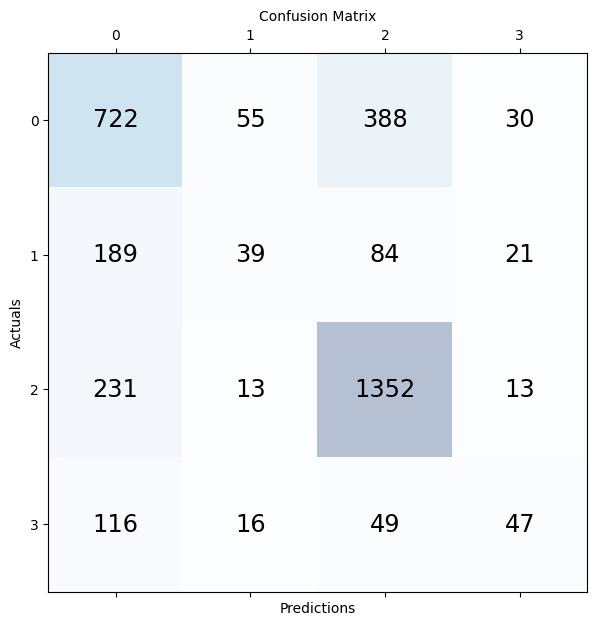

In [34]:
# Retrain on full training set using the best hyperparameters
best_model_reduced.fit(X_train_reduced, y_train_val)

# Make predictions on the test dataset
y_pred_test = best_model_reduced.predict(X_test_reduced)
print('test classification report')
print(classification_report(y_test, y_pred_test))

# Print the confusion matrix
fig, ax = plt.subplots(figsize=(7, 7))
confusion_mat = confusion_matrix(y_true=y_test, y_pred=y_pred_test, labels=[0,1,2,3])
ax.matshow(confusion_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_mat.shape[0]):
    for j in range(confusion_mat.shape[1]):
        ax.text(x=j, y=i,s=confusion_mat[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=10)
plt.ylabel('Actuals', fontsize=10)
plt.title('Confusion Matrix', fontsize=10)
plt.show()
print('\n')

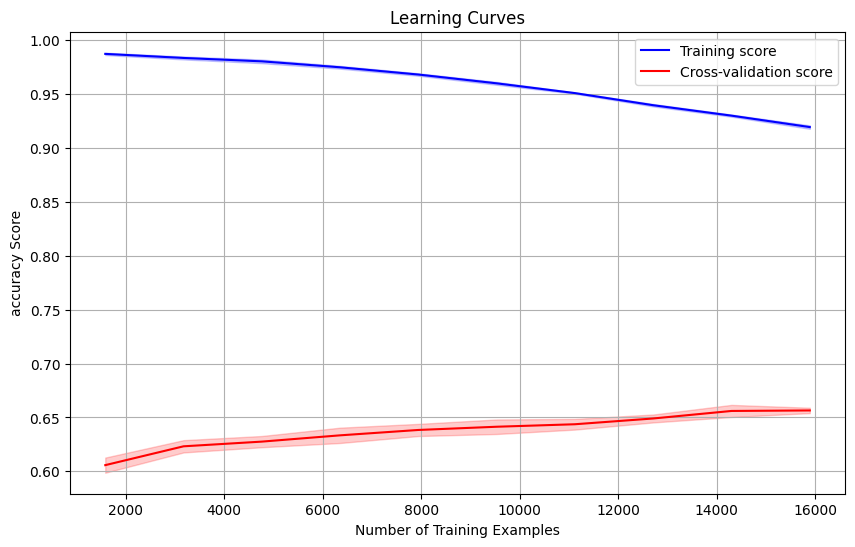

In [36]:
plot_learning_curve(best_model_reduced, X_train_reduced, y_train_val, 'accuracy')

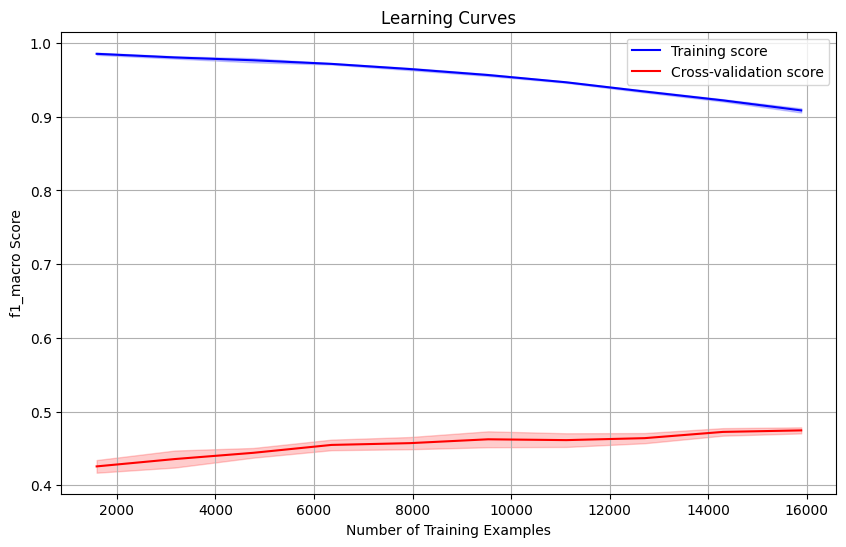

In [37]:
plot_learning_curve(best_model_reduced, X_train_reduced, y_train_val, 'f1_macro')